## Databricks Recommendation System - Music

## Installs:


In [0]:
!pip install scikit-image
!pip install spotipy

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.7 MB)
  Using cached imageio-2.33.1-py3-none-any.whl (313 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached tifffile-2024.1.30-py3-none-any.whl (224 kB)
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached spotipy-2.23.0-py3-none-any.whl (29 kB)
  Using cached redis-5.0.1-py3-none-any.whl (250 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl (5.7 kB)
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


## Imports:

In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import numpy  as np
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.functions import vector_to_array
import plotly.express as px
from scipy.spatial.distance import euclidean
from pyspark.sql.types import DoubleType
import spotipy
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials
from skimage import io
import matplotlib.pyplot as plt

## Loading the Data

In [0]:
## Checking the file directory: data
## To create the recommendation system, I will use the data file, as it has all the data we will need to create our recommendation ## system.
display(dbutils.fs.ls('/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/'))

path name size modificationTime dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/_committed_3177130763914826764 _committed_3177130763914826764 1607 1707232088000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/_committed_4818330780914731346 _committed_4818330780914731346 1607 1707247202000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/_committed_825971256025279735 _committed_825971256025279735 1607 1707232419000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/_committed_8775830171136009925 _committed_8775830171136009925 1626 1707220077000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/_started_4818330780914731346 _started_4818330780914731346 0 1707247187000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/_started_6474467209837860103 _started_6474467209837860103 0 1707170758000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/part-00000-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-76-1-c000.snappy.parquet part-00000-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-76-1-c000.snappy.parquet 1922693 1707247202000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/part-00001-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-77-1-c000.snappy.parquet part-00001-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-77-1-c000.snappy.parquet 1965917 1707247202000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/part-00002-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-78-1-c000.snappy.parquet part-00002-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-78-1-c000.snappy.parquet 2016846 1707247202000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/part-00003-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-79-1-c000.snappy.parquet part-00003-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-79-1-c000.snappy.parquet 2004281 1707247202000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/part-00004-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-80-1-c000.snappy.parquet part-00004-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-80-1-c000.snappy.parquet 2042813 1707247202000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/part-00005-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-81-1-c000.snappy.parquet part-00005-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-81-1-c000.snappy.parquet 2042273 1707247202000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/part-00006-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-82-1-c000.snappy.parquet part-00006-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-82-1-c000.snappy.parquet 2073423 1707247202000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/part-00007-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-83-1-c000.snappy.parquet part-00007-tid-4818330780914731346-18d38a58-857d-4df8-9ea1-9110f24247c0-83-1-c000.snappy.parquet 33000 1707247202000 dbfs:/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/part-00007-tid-6474467209837860103-722e9697-e5f3-4bf3-95a6-f6ec902121bf-198-1-c000.snappy.parquet part-00007-tid-6474467209837860103-722e9697-e5f3-4bf3-95a6-f6ec902121bf-198-1-c000.snappy.parquet 32592 1707170760000

In [0]:
# File location and file type
file_location = '/FileStore/tables/databricks-classes/Recommendation-System-Music/processed-data/data/'
file_type = 'parquet'

# Reading file
df_data = spark.read.format(file_type) \
    .load(file_location)

df_data.limit(10).display()

valence year acousticness artists danceability duration_ms energy explicit id instrumentalness key liveness loudness mode name popularity release_date speechiness tempo 0.917 1970 0.096 The Velvet Underground 0.624 201440 0.774 0 60ZyiL4lmWzZyGfqyECTqp 0.0309 7 0.096 -10.390999999999998 1 Train Round the Bend - 2015 Remaster 24 1970 0.0315 117.006 0.511 1970 0.0019 Ten Years After 0.405 458463 0.5429999999999999 0 6DYyyUdHzI6RdSx0swUR1i 0.72 2 0.18600000000000005 -9.313 1 Love Like a Man - 2017 Remaster 34 1970-04-01 0.029 107.598 0.466 1970 0.0528 The Mothers Of Invention 0.444 105587 0.568 0 6HJAS8XZO0ctUcN2KsbLRa 1.02E-5 11 0.512 -8.8 0 Oh No 24 1970-08-10 0.0327 124.319 0.523 1970 0.0811 Three Dog Night 0.502 174707 0.669 0 7sZ74qmKb1nyGKUgHROJ1n 9.45E-4 7 0.0906 -11.725 1 One Man Band 19 1970-01-01 0.0912 121.089 0.501 1970 1.28E-4 The Rolling Stones 0.273 246413 0.866 0 095WtNlSHE8TMB2gQ1fdTx 0.79 11 0.961 -7.598 1 Street Fighting Man - Live 25 1970-09-04 0.0347 134.891 0.8859999999999999 1970 0.25 Sly & The Family Stone 0.693 178360 0.6409999999999999 0 0aI5KoqucjqXjPi7bFENFQ 5.28E-4 0 0.0826 -9.99 1 Life 18 1970-11-21 0.0517 121.823 0.119 1970 0.13 William S. Fischer 0.231 273520 0.326 0 187c6h1frKYjnqKEoKPQQ6 0.287 4 0.106 -18.219 0 Chains 26 1970 0.0425 82.45200000000001 0.61 1970 0.6659999999999999 Yusuf / Cat Stevens 0.397 297107 0.634 0 27adiexGtJvf2NbH0GletP 6.799999999999999E-4 7 0.134 -7.787000000000001 1 On The Road To Find Out - Live At KCET-TV. 1971 27 1970-11-23 0.0343 179.516 0.556 1970 0.00674 The Meters 0.601 164000 0.439 0 2SJ5On3CJUop2H2uxTlovf 0.7609999999999999 6 0.0827 -13.213 0 Oh. Calcutta 23 1970 0.0311 102.344 0.317 1970 0.746 Linda Ronstadt 0.341 172707 0.35700000000000004 0 2XCtrbGnYP8inx76lmxXyt 4.47E-6 2 0.454 -13.245 1 Are My Thoughts With YouQ 20 1970 0.0385 123.604

## Analyzing the data

In [0]:
df_data.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)



## Checking if there is null data

In [0]:
df_data.count(), len(df_data.columns)

(170653, 19)

In [0]:
for column in df_data.columns:
    null_count = df_data.filter(F.col(column).isNull()).count()
    print(f'The column {column} has {null_count} null values.')


The column valence has 0 null values.
The column year has 0 null values.
The column acousticness has 0 null values.
The column artists has 0 null values.
The column danceability has 573 null values.
The column duration_ms has 199 null values.
The column energy has 80 null values.
The column explicit has 47 null values.
The column id has 0 null values.
The column instrumentalness has 383 null values.
The column key has 202 null values.
The column liveness has 40 null values.
The column loudness has 32 null values.
The column mode has 18 null values.
The column name has 0 null values.
The column popularity has 1157 null values.
The column release_date has 0 null values.
The column speechiness has 611 null values.
The column tempo has 249 null values.


#### Considering our database in this case I will choose to remove null values from the database

In [0]:
df_data = df_data.dropna()

In [0]:
for column in df_data.columns:
    null_count = df_data.filter(F.col(column).isNull()).count()
    print(f'The column {column} has {null_count} null values.')

The column valence has 0 null values.
The column year has 0 null values.
The column acousticness has 0 null values.
The column artists has 0 null values.
The column danceability has 0 null values.
The column duration_ms has 0 null values.
The column energy has 0 null values.
The column explicit has 0 null values.
The column id has 0 null values.
The column instrumentalness has 0 null values.
The column key has 0 null values.
The column liveness has 0 null values.
The column loudness has 0 null values.
The column mode has 0 null values.
The column name has 0 null values.
The column popularity has 0 null values.
The column release_date has 0 null values.
The column speechiness has 0 null values.
The column tempo has 0 null values.


In [0]:
df_data.describe().display()

summary valence year acousticness artists danceability duration_ms energy explicit id instrumentalness key liveness loudness mode name popularity release_date speechiness tempo count 169300 169300 169300 169300 169300 169300 169300 169300 169300 169300 169300 169300 169300 169300 169300 169300 169300 169300 169300 mean 0.5305294095871215 1976.9207619610158 0.4993497455324318 419.12048192771084 0.5385922191376249 230830.43981098643 0.4841806907885415 0.08506202008269344 null 0.16690738385020726 5.202161842882457 0.2056324197873595 -11.429420602480784 0.7067454223272298 Infinity 31.58238038984052 1962.9550561797753 0.09845073538098108 116.95988662138197 stddev 0.2624615102512805 25.914419740662932 0.37558542362217406 417.014253648609 0.17558334964851216 125650.80276192434 0.2673620824916626 0.2789747883241529 null 0.31340462030131777 3.515256736286112 0.1747500660607591 5.6780322162813786 0.45525548272333455 NaN 21.78434366812521 22.069954488916327 0.16305110855736743 30.687864105238116 min 0.0 1921 0.0 *NSYNC 0.0 5108 0.0 0 000G1xMMuwxNHmwVsBdtj1 0.0 0 0.0 -60.0 0 Cello Song 0 1921 0.0 0.0 max 1.0 2020 0.996 조정현 0.988 5403500 1.0 1 7zzuPsjj9L3M7ikqGmjN0D 1.0 11 1.0 3.855 1 텅 빈 마음 Empty Heart 100 2020-11-24 0.97 243.507

## Creating a new column with the names of artists and songs

In [0]:
df_data.limit(10).display()

valence year acousticness artists danceability duration_ms energy explicit id instrumentalness key liveness loudness mode name popularity release_date speechiness tempo 0.917 1970 0.096 The Velvet Underground 0.624 201440 0.774 0 60ZyiL4lmWzZyGfqyECTqp 0.0309 7 0.096 -10.390999999999998 1 Train Round the Bend - 2015 Remaster 24 1970 0.0315 117.006 0.511 1970 0.0019 Ten Years After 0.405 458463 0.5429999999999999 0 6DYyyUdHzI6RdSx0swUR1i 0.72 2 0.18600000000000005 -9.313 1 Love Like a Man - 2017 Remaster 34 1970-04-01 0.029 107.598 0.466 1970 0.0528 The Mothers Of Invention 0.444 105587 0.568 0 6HJAS8XZO0ctUcN2KsbLRa 1.02E-5 11 0.512 -8.8 0 Oh No 24 1970-08-10 0.0327 124.319 0.523 1970 0.0811 Three Dog Night 0.502 174707 0.669 0 7sZ74qmKb1nyGKUgHROJ1n 9.45E-4 7 0.0906 -11.725 1 One Man Band 19 1970-01-01 0.0912 121.089 0.501 1970 1.28E-4 The Rolling Stones 0.273 246413 0.866 0 095WtNlSHE8TMB2gQ1fdTx 0.79 11 0.961 -7.598 1 Street Fighting Man - Live 25 1970-09-04 0.0347 134.891 0.8859999999999999 1970 0.25 Sly & The Family Stone 0.693 178360 0.6409999999999999 0 0aI5KoqucjqXjPi7bFENFQ 5.28E-4 0 0.0826 -9.99 1 Life 18 1970-11-21 0.0517 121.823 0.119 1970 0.13 William S. Fischer 0.231 273520 0.326 0 187c6h1frKYjnqKEoKPQQ6 0.287 4 0.106 -18.219 0 Chains 26 1970 0.0425 82.45200000000001 0.61 1970 0.6659999999999999 Yusuf / Cat Stevens 0.397 297107 0.634 0 27adiexGtJvf2NbH0GletP 6.799999999999999E-4 7 0.134 -7.787000000000001 1 On The Road To Find Out - Live At KCET-TV. 1971 27 1970-11-23 0.0343 179.516 0.556 1970 0.00674 The Meters 0.601 164000 0.439 0 2SJ5On3CJUop2H2uxTlovf 0.7609999999999999 6 0.0827 -13.213 0 Oh. Calcutta 23 1970 0.0311 102.344 0.317 1970 0.746 Linda Ronstadt 0.341 172707 0.35700000000000004 0 2XCtrbGnYP8inx76lmxXyt 4.47E-6 2 0.454 -13.245 1 Are My Thoughts With YouQ 20 1970 0.0385 123.604

In [0]:
df_data \
    .withColumn('artists_song', F.concat(F.col('artists'), F.lit(' - '), F.col('name'))) \
    .limit(10) \
    .display()

valence year acousticness artists danceability duration_ms energy explicit id instrumentalness key liveness loudness mode name popularity release_date speechiness tempo artists_song 0.917 1970 0.096 The Velvet Underground 0.624 201440 0.774 0 60ZyiL4lmWzZyGfqyECTqp 0.0309 7 0.096 -10.390999999999998 1 Train Round the Bend - 2015 Remaster 24 1970 0.0315 117.006 The Velvet Underground - Train Round the Bend - 2015 Remaster 0.511 1970 0.0019 Ten Years After 0.405 458463 0.5429999999999999 0 6DYyyUdHzI6RdSx0swUR1i 0.72 2 0.18600000000000005 -9.313 1 Love Like a Man - 2017 Remaster 34 1970-04-01 0.029 107.598 Ten Years After - Love Like a Man - 2017 Remaster 0.466 1970 0.0528 The Mothers Of Invention 0.444 105587 0.568 0 6HJAS8XZO0ctUcN2KsbLRa 1.02E-5 11 0.512 -8.8 0 Oh No 24 1970-08-10 0.0327 124.319 The Mothers Of Invention - Oh No 0.523 1970 0.0811 Three Dog Night 0.502 174707 0.669 0 7sZ74qmKb1nyGKUgHROJ1n 9.45E-4 7 0.0906 -11.725 1 One Man Band 19 1970-01-01 0.0912 121.089 Three Dog Night - One Man Band 0.501 1970 1.28E-4 The Rolling Stones 0.273 246413 0.866 0 095WtNlSHE8TMB2gQ1fdTx 0.79 11 0.961 -7.598 1 Street Fighting Man - Live 25 1970-09-04 0.0347 134.891 The Rolling Stones - Street Fighting Man - Live 0.8859999999999999 1970 0.25 Sly & The Family Stone 0.693 178360 0.6409999999999999 0 0aI5KoqucjqXjPi7bFENFQ 5.28E-4 0 0.0826 -9.99 1 Life 18 1970-11-21 0.0517 121.823 Sly & The Family Stone - Life 0.119 1970 0.13 William S. Fischer 0.231 273520 0.326 0 187c6h1frKYjnqKEoKPQQ6 0.287 4 0.106 -18.219 0 Chains 26 1970 0.0425 82.45200000000001 William S. Fischer - Chains 0.61 1970 0.6659999999999999 Yusuf / Cat Stevens 0.397 297107 0.634 0 27adiexGtJvf2NbH0GletP 6.799999999999999E-4 7 0.134 -7.787000000000001 1 On The Road To Find Out - Live At KCET-TV. 1971 27 1970-11-23 0.0343 179.516 Yusuf / Cat Stevens - On The Road To Find Out - Live At KCET-TV. 1971 0.556 1970 0.00674 The Meters 0.601 164000 0.439 0 2SJ5On3CJUop2H2uxTlovf 0.7609999999999999 6 0.0827 -13.213 0 Oh. Calcutta 23 1970 0.0311 102.344 The Meters - Oh. Calcutta 0.317 1970 0.746 Linda Ronstadt 0.341 172707 0.35700000000000004 0 2XCtrbGnYP8inx76lmxXyt 4.47E-6 2 0.454 -13.245 1 Are My Thoughts With YouQ 20 1970 0.0385 123.604 Linda Ronstadt - Are My Thoughts With YouQ

In [0]:
df_data = df_data \
    .withColumn('artists_song', F.concat(F.col('artists'), F.lit(' - '), F.col('name')))

## Determining the features

In [0]:
X = df_data.columns
X.remove('artists')
X.remove('id')
X.remove('release_date')
X.remove('name')
X.remove('artists_song')
X

['valence',
 'year',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'speechiness',
 'tempo']

## Vectorizing the data

In [0]:
data_encoded_vector = VectorAssembler(
    inputCols = X,
    outputCol = 'features',
).transform(df_data)

In [0]:
data_encoded_vector.select('features').limit(10).display()

features Map(vectorType -> dense, length -> 15, values -> List(0.917, 1970.0, 0.096, 0.624, 201440.0, 0.774, 0.0, 0.0309, 7.0, 0.096, -10.390999999999998, 1.0, 24.0, 0.0315, 117.006)) Map(vectorType -> dense, length -> 15, values -> List(0.511, 1970.0, 0.0019, 0.405, 458463.0, 0.5429999999999999, 0.0, 0.72, 2.0, 0.18600000000000005, -9.313, 1.0, 34.0, 0.029, 107.598)) Map(vectorType -> dense, length -> 15, values -> List(0.466, 1970.0, 0.0528, 0.444, 105587.0, 0.568, 0.0, 1.02E-5, 11.0, 0.512, -8.8, 0.0, 24.0, 0.0327, 124.319)) Map(vectorType -> dense, length -> 15, values -> List(0.523, 1970.0, 0.0811, 0.502, 174707.0, 0.669, 0.0, 9.45E-4, 7.0, 0.0906, -11.725, 1.0, 19.0, 0.0912, 121.089)) Map(vectorType -> dense, length -> 15, values -> List(0.501, 1970.0, 1.28E-4, 0.273, 246413.0, 0.866, 0.0, 0.79, 11.0, 0.961, -7.598, 1.0, 25.0, 0.0347, 134.891)) Map(vectorType -> dense, length -> 15, values -> List(0.8859999999999999, 1970.0, 0.25, 0.693, 178360.0, 0.6409999999999999, 0.0, 5.28E-4, 0.0, 0.0826, -9.99, 1.0, 18.0, 0.0517, 121.823)) Map(vectorType -> dense, length -> 15, values -> List(0.119, 1970.0, 0.13, 0.231, 273520.0, 0.326, 0.0, 0.287, 4.0, 0.106, -18.219, 0.0, 26.0, 0.0425, 82.45200000000001)) Map(vectorType -> dense, length -> 15, values -> List(0.61, 1970.0, 0.6659999999999999, 0.397, 297107.0, 0.634, 0.0, 6.799999999999999E-4, 7.0, 0.134, -7.787000000000001, 1.0, 27.0, 0.0343, 179.516)) Map(vectorType -> dense, length -> 15, values -> List(0.556, 1970.0, 0.00674, 0.601, 164000.0, 0.439, 0.0, 0.7609999999999999, 6.0, 0.0827, -13.213, 0.0, 23.0, 0.0311, 102.344)) Map(vectorType -> dense, length -> 15, values -> List(0.317, 1970.0, 0.746, 0.341, 172707.0, 0.35700000000000004, 0.0, 4.47E-6, 2.0, 0.454, -13.245, 1.0, 20.0, 0.0385, 123.604))

## Normalizing the data: StandardScaler

In [0]:
scaler = StandardScaler(
    inputCol = 'features',
    outputCol = 'features_scaled'
)

In [0]:
model_scaler = scaler.fit(data_encoded_vector)

In [0]:
data_music_scaler = model_scaler.transform(data_encoded_vector)

In [0]:
data_music_scaler.select('features', 'features_scaled').limit(10).display()

features features_scaled Map(vectorType -> dense, length -> 15, values -> List(0.917, 1970.0, 0.096, 0.624, 201440.0, 0.774, 0.0, 0.0309, 7.0, 0.096, -10.390999999999998, 1.0, 24.0, 0.0315, 117.006)) Map(vectorType -> dense, length -> 15, values -> List(3.493845627581973, 76.0194524791472, 0.25560097373899326, 3.553867728626555, 1.6031732036099804, 2.8949505209817366, 0.0, 0.09859458986370954, 1.9913197029800866, 0.5493560155028588, -1.830035407373086, 2.196568823329722, 1.101708656713709, 0.19319095882698092, 3.8127775722269495)) Map(vectorType -> dense, length -> 15, values -> List(0.511, 1970.0, 0.0019, 0.405, 458463.0, 0.5429999999999999, 0.0, 0.72, 2.0, 0.18600000000000005, -9.313, 1.0, 34.0, 0.029, 107.598)) Map(vectorType -> dense, length -> 15, values -> List(1.9469521436143817, 76.0194524791472, 0.0050587692719175755, 2.306596843098966, 3.648707289747034, 2.0309536600685822, 0.0, 2.2973496667272126, 0.568948486565739, 1.0643772800367892, -1.6401809016327162, 2.196568823329722, 1.5607539303444211, 0.1778583430470618, 3.5062068715832977)) Map(vectorType -> dense, length -> 15, values -> List(0.466, 1970.0, 0.0528, 0.444, 105587.0, 0.568, 0.0, 1.02E-5, 11.0, 0.512, -8.8, 0.0, 24.0, 0.0327, 124.319)) Map(vectorType -> dense, length -> 15, values -> List(1.7754984323371859, 76.0194524791472, 0.1405805355564463, 2.528713576138126, 0.8403209345192961, 2.124459813847062, 0.0, 3.254578694530218E-5, 3.1292166761115645, 2.92989874934858, -1.5498326999213896, 0.0, 1.101708656713709, 0.20055061440134211, 4.05108024376256)) Map(vectorType -> dense, length -> 15, values -> List(0.523, 1970.0, 0.0811, 0.502, 174707.0, 0.669, 0.0, 9.45E-4, 7.0, 0.0906, -11.725, 1.0, 19.0, 0.0912, 121.089)) Map(vectorType -> dense, length -> 15, values -> List(1.9926731332883008, 76.0194524791472, 0.21592957260658704, 2.859041025273286, 1.39041690271589, 2.5022246751121213, 0.0, 0.0030152714375794665, 1.9913197029800866, 0.518454739630823, -2.064975955292988, 2.196568823329722, 0.8721860198983531, 0.5593338236514496, 3.9458269101019527)) Map(vectorType -> dense, length -> 15, values -> List(0.501, 1970.0, 1.28E-4, 0.273, 246413.0, 0.866, 0.0, 0.79, 11.0, 0.961, -7.598, 1.0, 25.0, 0.0347, 134.891)) Map(vectorType -> dense, length -> 15, values -> List(1.908851318886116, 76.0194524791472, 3.408012983186577E-4, 1.554817131274118, 1.9610937183337278, 3.2390531668865425, 0.0, 2.5207031065479137, 3.1292166761115645, 5.499282613523409, -1.338139642500309, 2.196568823329722, 1.1476131840767803, 0.2128167070252774, 4.395581247929726)) Map(vectorType -> dense, length -> 15, values -> List(0.8859999999999999, 1970.0, 0.25, 0.693, 178360.0, 0.6409999999999999, 0.0, 5.28E-4, 0.0, 0.0826, -9.99, 1.0, 18.0, 0.0517, 121.823)) Map(vectorType -> dense, length -> 15, values -> List(3.3757330709243485, 76.0194524791472, 0.6656275357786283, 3.9468434870804527, 1.4194895383035946, 2.3974977828802233, 0.0, 0.0016847230889332893, 0.0, 0.4726750716722514, -1.7594123491153049, 2.196568823329722, 0.8262814925352818, 0.3170784943287274, 3.969745159918326)) Map(vectorType -> dense, length -> 15, values -> List(0.119, 1970.0, 0.13, 0.231, 273520.0, 0.326, 0.0, 0.287, 4.0, 0.106, -18.219, 0.0, 26.0, 0.0425, 82.45200000000001)) Map(vectorType -> dense, length -> 15, values -> List(0.45339981426636283, 76.0194524791472, 0.34612631860488674, 1.3156144956934843, 2.1768265222964747, 1.2193202452713774, 0.0, 0.9157491032648749, 1.137896973131478, 0.6065806004510732, -3.208682040894068, 0.0, 1.1935177114398514, 0.2606544682586251, 2.686795005258333)) Map(vectorType -> dense, length -> 15, values -> List(0.61, 1970.0, 0.6659999999999999, 0.397, 297107.0, 0.634, 0.0, 6.799999999999999E-4, 7.0, 0.134, -7.787000000000001, 1.0, 27.0, 0.0343, 179.516)) Map(vectorType -> dense, length -> 15, values -> List(2.3241503084242128, 76.0194524791472, 1.7732317553142656, 2.2610344363217028, 2.3645451797306913, 2.371316059822249, 0.0, 0.0021697191296868117, 1.9913197029800866, 0.7668094383060737, -1.37142

## Dimensionality reduction PCA

### Defining the value of K to determine the number of features to work on dimensionality reduction through PCA

In [0]:
len(X)

15

In [0]:
k = len(X)

In [0]:
pca = PCA(
    k = k,
    inputCol = 'features_scaled',
    outputCol = 'pca_features'
)

In [0]:
model_pca = pca.fit(data_music_scaler)

In [0]:
data_music_pca = model_pca.transform(data_music_scaler)

In [0]:
data_music_pca.select('features_scaled', 'pca_features').limit(10).display()

features_scaled pca_features Map(vectorType -> dense, length -> 15, values -> List(3.493845627581973, 76.0194524791472, 0.25560097373899326, 3.553867728626555, 1.6031732036099804, 2.8949505209817366, 0.0, 0.09859458986370954, 1.9913197029800866, 0.5493560155028588, -1.830035407373086, 2.196568823329722, 1.101708656713709, 0.19319095882698092, 3.8127775722269495)) Map(vectorType -> dense, length -> 15, values -> List(-32.317253724078746, -18.92501013127843, 10.927714292203623, -14.569692108954658, -3.181740349541969, 4.244071962867795, -4.406015659069031, 0.39558919492808753, -6.744924101473277, -26.674834244648505, 5.598083789833302, 5.702654739417551, -11.480555150901818, -52.57138550084649, -18.56446410894391)) Map(vectorType -> dense, length -> 15, values -> List(1.9469521436143817, 76.0194524791472, 0.0050587692719175755, 2.306596843098966, 3.648707289747034, 2.0309536600685822, 0.0, 2.2973496667272126, 0.568948486565739, 1.0643772800367892, -1.6401809016327162, 2.196568823329722, 1.5607539303444211, 0.1778583430470618, 3.5062068715832977)) Map(vectorType -> dense, length -> 15, values -> List(-31.13281822178284, -21.34230486564095, 12.383759684804442, -13.755472800980932, -3.8902954615774172, 3.440922089757806, -2.8095715292076555, 0.11119509212835099, -7.683927911495577, -26.755120341689924, 5.6842335580713135, 6.3119822461400865, -11.52151684734756, -51.74365600983111, -19.368459236030525)) Map(vectorType -> dense, length -> 15, values -> List(1.7754984323371859, 76.0194524791472, 0.1405805355564463, 2.528713576138126, 0.8403209345192961, 2.124459813847062, 0.0, 3.254578694530218E-5, 3.1292166761115645, 2.92989874934858, -1.5498326999213896, 0.0, 1.101708656713709, 0.20055061440134211, 4.05108024376256)) Map(vectorType -> dense, length -> 15, values -> List(-31.78064916266867, -19.569645663588197, 12.541114621263848, -12.785799961142185, -1.5971144308355876, 4.985715880825121, -5.484833765477134, 2.5039608634483046, -6.11400058144517, -27.240513922258003, 5.467671166734876, 6.124972841203548, -10.761158980215646, -52.190552837753216, -19.188401038794822)) Map(vectorType -> dense, length -> 15, values -> List(1.9926731332883008, 76.0194524791472, 0.21592957260658704, 2.859041025273286, 1.39041690271589, 2.5022246751121213, 0.0, 0.0030152714375794665, 1.9913197029800866, 0.518454739630823, -2.064975955292988, 2.196568823329722, 0.8721860198983531, 0.5593338236514496, 3.9458269101019527)) Map(vectorType -> dense, length -> 15, values -> List(-31.605844893175377, -19.547985862609575, 11.83344820576472, -14.450217738392594, -3.507001915378802, 4.9497172630424835, -4.726524305351937, 0.5972927170370553, -6.360166940606295, -26.2578530068697, 5.932917422275927, 6.027049585498366, -11.050435060707056, -52.624662631023035, -18.628007943810612)) Map(vectorType -> dense, length -> 15, values -> List(1.908851318886116, 76.0194524791472, 3.408012983186577E-4, 1.554817131274118, 1.9610937183337278, 3.2390531668865425, 0.0, 2.5207031065479137, 3.1292166761115645, 5.499282613523409, -1.338139642500309, 2.196568823329722, 1.1476131840767803, 0.2128167070252774, 4.395581247929726)) Map(vectorType -> dense, length -> 15, values -> List(-31.594059088957625, -20.741768225806354, 12.379789932280918, -9.883622640679858, -2.6591844061390413, 4.548614976465258, -5.696100278787487, 1.5326210798264992, -9.037872643320508, -27.909712525390365, 5.497300122384698, 6.392494948473286, -11.167121597273793, -52.0739163901576, -19.053069961701922)) Map(vectorType -> dense, length -> 15, values -> List(3.3757330709243485, 76.0194524791472, 0.6656275357786283, 3.9468434870804527, 1.4194895383035946, 2.3974977828802233, 0.0, 0.0016847230889332893, 0.0, 0.4726750716722514, -1.7594123491153049, 2.196568823329722, 0.8262814925352818, 0.3170784943287274, 3.969745159918326)) Map(vectorType -> dense, length -> 15, values -> List(-31.938780024366526, -18.641276555598704, 10.788192154460525, -14.83668879037311, -4.580742030187444, 3.9910349077588387, -3.23602999858

In [0]:
model_pca.explainedVariance

DenseVector([0.2656, 0.1207, 0.095, 0.0785, 0.0743, 0.0627, 0.0611, 0.0561, 0.05, 0.0418, 0.0342, 0.0227, 0.0203, 0.0089, 0.008])

In [0]:
sum(model_pca.explainedVariance) * 100

99.99999999999999

### Adjusting the number of components so that we have an explanation of 70% of the features in the dataset

In [0]:
list_values = [sum(model_pca.explainedVariance[0 : i + 1]) for i in range(k)]
list_values

[0.2655954620157461,
 0.38633995568156554,
 0.4813130666596819,
 0.5598342425313094,
 0.6341616245863153,
 0.6968259227182989,
 0.7579363400230548,
 0.8140504754940462,
 0.8640376949888984,
 0.9058308612627601,
 0.9400513661542069,
 0.9627442126908644,
 0.9830935482319771,
 0.9919540017169319,
 0.9999999999999999]

In [0]:
np.array(list_values)

array([0.26559546, 0.38633996, 0.48131307, 0.55983424, 0.63416162,
       0.69682592, 0.75793634, 0.81405048, 0.86403769, 0.90583086,
       0.94005137, 0.96274421, 0.98309355, 0.991954  , 1.        ])

In [0]:
k = sum(np.array(list_values) <= 0.8)
k

7

## PCA >>> k = 7

In [0]:
pca_k7 = PCA(
    k = k,
    inputCol = 'features_scaled',
    outputCol = 'pca_features'
)

In [0]:
model_pca_k7 = pca_k7.fit(data_music_scaler)

In [0]:
data_music_pca_k7 = model_pca_k7.transform(data_music_scaler)

In [0]:
data_music_pca_k7.select('pca_features').limit(10).display()

pca_features Map(vectorType -> dense, length -> 7, values -> List(-32.317253724078746, -18.92501013127843, 10.927714292203623, -14.569692108954658, -3.1817403495419683, 4.244071962867795, -4.406015659069031)) Map(vectorType -> dense, length -> 7, values -> List(-31.13281822178284, -21.34230486564095, 12.383759684804442, -13.755472800980932, -3.890295461577418, 3.440922089757806, -2.8095715292076555)) Map(vectorType -> dense, length -> 7, values -> List(-31.78064916266867, -19.569645663588197, 12.541114621263848, -12.785799961142185, -1.5971144308355871, 4.985715880825121, -5.484833765477134)) Map(vectorType -> dense, length -> 7, values -> List(-31.605844893175377, -19.547985862609575, 11.83344820576472, -14.450217738392594, -3.507001915378801, 4.9497172630424835, -4.726524305351937)) Map(vectorType -> dense, length -> 7, values -> List(-31.594059088957625, -20.741768225806354, 12.379789932280918, -9.883622640679858, -2.6591844061390417, 4.548614976465258, -5.696100278787488)) Map(vectorType -> dense, length -> 7, values -> List(-31.938780024366526, -18.641276555598704, 10.788192154460525, -14.83668879037311, -4.580742030187444, 3.9910349077588387, -3.2360299985816656)) Map(vectorType -> dense, length -> 7, values -> List(-29.686935486197275, -21.433187568001365, 13.838957095677145, -14.781810266213547, -2.7714986647655566, 4.228380981040203, -3.7384809071959317)) Map(vectorType -> dense, length -> 7, values -> List(-31.53916734666039, -20.17253223596157, 11.199290425576377, -13.509815154344603, -3.3677389743533865, 5.988035819971133, -3.9816405699561335)) Map(vectorType -> dense, length -> 7, values -> List(-30.771547827750275, -19.778300972177476, 12.38180791993549, -15.207665081457929, -1.8486921203685784, 4.305524129220872, -3.1230838459828503)) Map(vectorType -> dense, length -> 7, values -> List(-29.965130076522147, -20.250087789172746, 12.309162114586268, -13.17505582153397, -4.853288314827287, 4.7591936693673755, -4.808961603995311))

In [0]:
model_pca_k7.explainedVariance

DenseVector([0.2656, 0.1207, 0.095, 0.0785, 0.0743, 0.0627, 0.0611])

In [0]:
sum(model_pca_k7.explainedVariance) * 100

75.79363400230548

## Creating pipeline

In [0]:
pipeline = Pipeline(stages = [
    VectorAssembler(inputCols = X, outputCol = 'features'),
    StandardScaler(inputCol = 'features', outputCol = 'features_scaled'),
    PCA(k = 7, inputCol = 'features_scaled', outputCol = 'pca_features')
])

In [0]:
model_pipeline = pipeline.fit(df_data)

In [0]:
df_pca = model_pipeline.transform(df_data)

In [0]:
df_pca.limit(10).display()

valence year acousticness artists danceability duration_ms energy explicit id instrumentalness key liveness loudness mode name popularity release_date speechiness tempo artists_song features features_scaled pca_features 0.917 1970 0.096 The Velvet Underground 0.624 201440 0.774 0 60ZyiL4lmWzZyGfqyECTqp 0.0309 7 0.096 -10.390999999999998 1 Train Round the Bend - 2015 Remaster 24 1970 0.0315 117.006 The Velvet Underground - Train Round the Bend - 2015 Remaster Map(vectorType -> dense, length -> 15, values -> List(0.917, 1970.0, 0.096, 0.624, 201440.0, 0.774, 0.0, 0.0309, 7.0, 0.096, -10.390999999999998, 1.0, 24.0, 0.0315, 117.006)) Map(vectorType -> dense, length -> 15, values -> List(3.493845627581973, 76.0194524791472, 0.25560097373899326, 3.553867728626555, 1.6031732036099804, 2.8949505209817366, 0.0, 0.09859458986370954, 1.9913197029800866, 0.5493560155028588, -1.830035407373086, 2.196568823329722, 1.101708656713709, 0.19319095882698092, 3.8127775722269495)) Map(vectorType -> dense, length -> 7, values -> List(-32.317253724078746, -18.92501013127843, 10.927714292203623, -14.569692108954658, -3.1817403495419683, 4.244071962867795, -4.406015659069031)) 0.511 1970 0.0019 Ten Years After 0.405 458463 0.5429999999999999 0 6DYyyUdHzI6RdSx0swUR1i 0.72 2 0.18600000000000005 -9.313 1 Love Like a Man - 2017 Remaster 34 1970-04-01 0.029 107.598 Ten Years After - Love Like a Man - 2017 Remaster Map(vectorType -> dense, length -> 15, values -> List(0.511, 1970.0, 0.0019, 0.405, 458463.0, 0.5429999999999999, 0.0, 0.72, 2.0, 0.18600000000000005, -9.313, 1.0, 34.0, 0.029, 107.598)) Map(vectorType -> dense, length -> 15, values -> List(1.9469521436143817, 76.0194524791472, 0.0050587692719175755, 2.306596843098966, 3.648707289747034, 2.0309536600685822, 0.0, 2.2973496667272126, 0.568948486565739, 1.0643772800367892, -1.6401809016327162, 2.196568823329722, 1.5607539303444211, 0.1778583430470618, 3.5062068715832977)) Map(vectorType -> dense, length -> 7, values -> List(-31.13281822178284, -21.34230486564095, 12.383759684804442, -13.755472800980932, -3.890295461577418, 3.440922089757806, -2.8095715292076555)) 0.466 1970 0.0528 The Mothers Of Invention 0.444 105587 0.568 0 6HJAS8XZO0ctUcN2KsbLRa 1.02E-5 11 0.512 -8.8 0 Oh No 24 1970-08-10 0.0327 124.319 The Mothers Of Invention - Oh No Map(vectorType -> dense, length -> 15, values -> List(0.466, 1970.0, 0.0528, 0.444, 105587.0, 0.568, 0.0, 1.02E-5, 11.0, 0.512, -8.8, 0.0, 24.0, 0.0327, 124.319)) Map(vectorType -> dense, length -> 15, values -> List(1.7754984323371859, 76.0194524791472, 0.1405805355564463, 2.528713576138126, 0.8403209345192961, 2.124459813847062, 0.0, 3.254578694530218E-5, 3.1292166761115645, 2.92989874934858, -1.5498326999213896, 0.0, 1.101708656713709, 0.20055061440134211, 4.05108024376256)) Map(vectorType -> dense, length -> 7, values -> List(-31.78064916266867, -19.569645663588197, 12.541114621263848, -12.785799961142185, -1.5971144308355871, 4.985715880825121, -5.484833765477134)) 0.523 1970 0.0811 Three Dog Night 0.502 174707 0.669 0 7sZ74qmKb1nyGKUgHROJ1n 9.45E-4 7 0.0906 -11.725 1 One Man Band 19 1970-01-01 0.0912 121.089 Three Dog Night - One Man Band Map(vectorType -> dense, length -> 15, values -> List(0.523, 1970.0, 0.0811, 0.502, 174707.0, 0.669, 0.0, 9.45E-4, 7.0, 0.0906, -11.725, 1.0, 19.0, 0.0912, 121.089)) Map(vectorType -> dense, length -> 15, values -> List(1.9926731332883008, 76.0194524791472, 0.21592957260658704, 2.859041025273286, 1.39041690271589, 2.5022246751121213, 0.0, 0.0030152714375794665, 1.9913197029800866, 0.518454739630823, -2.064975955292988, 2.196568823329722, 0.8721860198983531, 0.5593338236514496, 3.9458269101019527)) Map(vectorType -> dense, length -> 7, values -> List(-31.605844893175377, -19.547985862609575, 11.83344820576472, -14.450217738392594, -3.507001915378801, 4.9497172630424835, -4.726524305351937)) 0.501 1970 1.28E-4 The Rolling Stones 0.273 246413 0.866 0 095WtNlSHE8TMB2gQ1fdTx 0.79 11 0.961 -7.598 1 Street Fighting Man - Live 25 19

## Assembling the clusters: KMeans

### Defining the seed for training our clusters

In [0]:
SEED  = 333

In [0]:
kmeans = KMeans(
    k = 500,
    featuresCol = 'pca_features',
    predictionCol = 'cluster_pca',
    seed = SEED
)

In [0]:
model_kmeans = kmeans.fit(df_pca)

In [0]:
projection_kmeans = model_kmeans.transform(df_pca)

In [0]:
projection_kmeans.select('pca_features', 'cluster_pca').limit(10).display()

pca_features cluster_pca Map(vectorType -> dense, length -> 7, values -> List(-32.317253724078746, -18.92501013127843, 10.927714292203623, -14.569692108954658, -3.1817403495419683, 4.244071962867795, -4.406015659069031)) 268 Map(vectorType -> dense, length -> 7, values -> List(-31.13281822178284, -21.34230486564095, 12.383759684804442, -13.755472800980932, -3.890295461577418, 3.440922089757806, -2.8095715292076555)) 35 Map(vectorType -> dense, length -> 7, values -> List(-31.78064916266867, -19.569645663588197, 12.541114621263848, -12.785799961142185, -1.5971144308355871, 4.985715880825121, -5.484833765477134)) 426 Map(vectorType -> dense, length -> 7, values -> List(-31.605844893175377, -19.547985862609575, 11.83344820576472, -14.450217738392594, -3.507001915378801, 4.9497172630424835, -4.726524305351937)) 220 Map(vectorType -> dense, length -> 7, values -> List(-31.594059088957625, -20.741768225806354, 12.379789932280918, -9.883622640679858, -2.6591844061390417, 4.548614976465258, -5.696100278787488)) 117 Map(vectorType -> dense, length -> 7, values -> List(-31.938780024366526, -18.641276555598704, 10.788192154460525, -14.83668879037311, -4.580742030187444, 3.9910349077588387, -3.2360299985816656)) 281 Map(vectorType -> dense, length -> 7, values -> List(-29.686935486197275, -21.433187568001365, 13.838957095677145, -14.781810266213547, -2.7714986647655566, 4.228380981040203, -3.7384809071959317)) 100 Map(vectorType -> dense, length -> 7, values -> List(-31.53916734666039, -20.17253223596157, 11.199290425576377, -13.509815154344603, -3.3677389743533865, 5.988035819971133, -3.9816405699561335)) 492 Map(vectorType -> dense, length -> 7, values -> List(-30.771547827750275, -19.778300972177476, 12.38180791993549, -15.207665081457929, -1.8486921203685784, 4.305524129220872, -3.1230838459828503)) 192 Map(vectorType -> dense, length -> 7, values -> List(-29.965130076522147, -20.250087789172746, 12.309162114586268, -13.17505582153397, -4.853288314827287, 4.7591936693673755, -4.808961603995311)) 499

## Viewing results

In [0]:
# projection_kmeans_v = projection_kmeans \
    # .withColumn('X', vector_to_array('pca_features')[0]) \
    # .withColumn('Y', vector_to_array('pca_features')[1]) 


In [0]:
# fig = px.scatter(projection_kmeans_v.toPandas(), x = 'X', y = 'Y', color = 'cluster_pca', hover_data = ['artists_song'])
# fig.show()

## Creating recommender

In [0]:
name_song = 'Taylor Swift - Blank Space'

### Selecting cluster

In [0]:
cluster = projection_kmeans \
    .filter(projection_kmeans.artists_song == name_song) \
    .select('cluster_pca') \
    .collect()[0][0]
cluster

250

### List recommended songs

In [0]:
recommended_songs = projection_kmeans \
    .filter(projection_kmeans.cluster_pca == cluster) \
    .select('artists_song', 'id', 'pca_features')
recommended_songs.limit(10).display()

artists_song id pca_features Liquido - Narcotic - Radio Edit 1H5VQuShs4qfwBXyHF0PeH Map(vectorType -> dense, length -> 7, values -> List(-33.12826314844452, -20.758793845058975, 12.297040867707194, -15.487148563429969, -4.689633148680994, 3.814968480148498, -3.982977109438404)) Thalia - Entre El Mar Y Una Estrella 2KNtKG2X0jpOIgVunVbAkQ Map(vectorType -> dense, length -> 7, values -> List(-32.94716549734986, -20.29937280804034, 12.15496677581814, -15.07916355466503, -4.485459808068986, 3.4526352156120135, -4.365513850175784)) Zoé - Soñé 4oMaBqivBDg7ID3EHtydeX Map(vectorType -> dense, length -> 7, values -> List(-33.19795412587799, -20.19629024306445, 11.680243655737764, -15.246521919139706, -4.348024396584214, 3.5315947204450264, -4.200997399026704)) The Used - Listening 528rajP3OyhornDwrsQrt4 Map(vectorType -> dense, length -> 7, values -> List(-33.13468585619862, -20.580160007123474, 12.174815738497127, -15.061473798218664, -4.93827214078352, 3.955258128725847, -4.049806693851269)) blink-182 - Not Now 28yCMEplHbodvR19Aipah8 Map(vectorType -> dense, length -> 7, values -> List(-33.46383954091921, -20.92838080131983, 12.43915804679689, -14.8635289310595, -4.48870272609193, 3.941875636995829, -4.069583720830974)) Three 6 Mafia - Late Nite Tip 2LqYpghBcqTdcW2zi5CWWU Map(vectorType -> dense, length -> 7, values -> List(-32.79513493117875, -20.08364264992356, 12.81049923494719, -15.136923813673413, -4.588910681754793, 3.9174642717940333, -3.8966825214992706)) Red Hot Chili Peppers - Storm in a Teacup 1JTrNAEJN6HCviUe9xMpAq Map(vectorType -> dense, length -> 7, values -> List(-33.64030914023419, -20.794776373365263, 12.135797778981521, -14.852041330003342, -4.866522975263467, 3.798808628282923, -3.869492245966086)) James Morrison - Wonderful World 7EfHlhxyYJ5pfh0H34j7oe Map(vectorType -> dense, length -> 7, values -> List(-32.824433113392786, -20.471966084948452, 11.960374922271809, -15.141399537384192, -4.654142901273579, 3.3395500305876986, -4.314657628419825)) Aterciopelados - Bolero Falaz 6sayXgNAqCmfUAqGAxP4xA Map(vectorType -> dense, length -> 7, values -> List(-33.425671156789484, -20.09083449106532, 11.833919612857903, -15.36489582384944, -4.016109146771181, 4.031724503185284, -4.286115538312714)) Switchfoot - This Is Home 0jRuKrn7OOzriNlwFZAQco Map(vectorType -> dense, length -> 7, values -> List(-33.01108311563809, -20.845361871297513, 12.388457655965126, -15.038799352509082, -4.961229540369083, 3.9266001904721595, -3.9192029600507343))

### Extracting features from songs

In [0]:
song_components = projection_kmeans \
    .filter(projection_kmeans.artists_song == name_song) \
    .select('pca_features') \
    .collect()[0][0]
song_components

DenseVector([-33.6727, -20.0522, 12.1135, -15.6564, -3.8549, 3.5919, -4.657])

### Defining function to calculate the distance between songs

In [0]:
def calculate_distance(value):
    return euclidean(song_components, value)

### Converting the function to pyspark

In [0]:
udf_calculate_distance = F.udf(calculate_distance, DoubleType())

In [0]:
recommended_songs_distance = recommended_songs \
    .withColumn('distance', udf_calculate_distance('pca_features'))

In [0]:
recommended_songs_distance.limit(10).display()

artists_song id pca_features distance Liquido - Narcotic - Radio Edit 1H5VQuShs4qfwBXyHF0PeH Map(vectorType -> dense, length -> 7, values -> List(-33.12826314844452, -20.758793845058975, 12.297040867707194, -15.487148563429969, -4.689633148680994, 3.814968480148498, -3.982977109438404)) 1.4348638995948755 Thalia - Entre El Mar Y Una Estrella 2KNtKG2X0jpOIgVunVbAkQ Map(vectorType -> dense, length -> 7, values -> List(-32.94716549734986, -20.29937280804034, 12.15496677581814, -15.07916355466503, -4.485459808068986, 3.4526352156120135, -4.365513850175784)) 1.193437120962268 Zoé - Soñé 4oMaBqivBDg7ID3EHtydeX Map(vectorType -> dense, length -> 7, values -> List(-33.19795412587799, -20.19629024306445, 11.680243655737764, -15.246521919139706, -4.348024396584214, 3.5315947204450264, -4.200997399026704)) 1.0278755439263958 The Used - Listening 528rajP3OyhornDwrsQrt4 Map(vectorType -> dense, length -> 7, values -> List(-33.13468585619862, -20.580160007123474, 12.174815738497127, -15.061473798218664, -4.93827214078352, 3.955258128725847, -4.049806693851269)) 1.6125206555353615 blink-182 - Not Now 28yCMEplHbodvR19Aipah8 Map(vectorType -> dense, length -> 7, values -> List(-33.46383954091921, -20.92838080131983, 12.43915804679689, -14.8635289310595, -4.48870272609193, 3.941875636995829, -4.069583720830974)) 1.55409778980162 Three 6 Mafia - Late Nite Tip 2LqYpghBcqTdcW2zi5CWWU Map(vectorType -> dense, length -> 7, values -> List(-32.79513493117875, -20.08364264992356, 12.81049923494719, -15.136923813673413, -4.588910681754793, 3.9174642717940333, -3.8966825214992706)) 1.6581594816540022 Red Hot Chili Peppers - Storm in a Teacup 1JTrNAEJN6HCviUe9xMpAq Map(vectorType -> dense, length -> 7, values -> List(-33.64030914023419, -20.794776373365263, 12.135797778981521, -14.852041330003342, -4.866522975263467, 3.798808628282923, -3.869492245966086)) 1.6988921070877672 James Morrison - Wonderful World 7EfHlhxyYJ5pfh0H34j7oe Map(vectorType -> dense, length -> 7, values -> List(-32.824433113392786, -20.471966084948452, 11.960374922271809, -15.141399537384192, -4.654142901273579, 3.3395500305876986, -4.314657628419825)) 1.415633143216254 Aterciopelados - Bolero Falaz 6sayXgNAqCmfUAqGAxP4xA Map(vectorType -> dense, length -> 7, values -> List(-33.425671156789484, -20.09083449106532, 11.833919612857903, -15.36489582384944, -4.016109146771181, 4.031724503185284, -4.286115538312714)) 0.7632914926448343 Switchfoot - This Is Home 0jRuKrn7OOzriNlwFZAQco Map(vectorType -> dense, length -> 7, values -> List(-33.01108311563809, -20.845361871297513, 12.388457655965126, -15.038799352509082, -4.961229540369083, 3.9266001904721595, -3.9192029600507343)) 1.8450297067694905

In [0]:
recommended = spark.createDataFrame(
    recommended_songs_distance \
    .orderBy(F.col('distance').asc()) \
    .take(10)
) \
    .select('artists_song', 'id', 'distance')
recommended.display()

artists_song id distance Taylor Swift - Blank Space 1kHEuJRasudLhjvnbfc4yS 0.0 Taylor Swift - Blank Space 2sC2P3BN0IXujNaaSyDmtP 0.025498824926887178 Taylor Swift - Blank Space 1p80LdxRV74UKvL8gnD7ky 0.279458581200595 Jon Bellion - Morning In America 2JXNOtb0ANe6MzgRYDQG2J 0.3151996976929946 Kelsea Ballerini - Dibs 6FWrlXo99QRmPtOeUSWDjv 0.427752811364989 Walker Hayes - Dont Let Her 6UbUXwQn2CM5mb9vHgt1Gz 0.43027021129567405 Atomic Kitten - Whole Again 16MJqq0vEuW6GRX6faetTm 0.44748438547408825 Natasha Bedingfield - Unwritten 1D1nixOVWOxvNfWi0UD7VX 0.48219919732647976 The All-American Rejects - Gives You Hell 5gb9UJkh8TfrNMRYOJNbew 0.4824551242418128 The All-American Rejects - Gives You Hell 6ihL9TjfRjadfEePzXXyVF 0.49705836238574663

## Improving the code and creating a function for the recommender

In [0]:
def recommender(name_song):
    # Finding the music cluster
    cluster = projection_kmeans \
        .filter(F.col('artists_song') == name_song) \
        .select('cluster_pca') \
        .collect()[0][0]
    
    # Songs recommended
    songs_recommended = projection_kmeans \
        .filter(F.col('cluster_pca') == cluster) \
        .select('artists_song', 'id', 'pca_features')
    
    # Songs components
    songs_components = songs_recommended \
        .filter(F.col('artists_song') == name_song) \
        .select('pca_features') \
        .collect()[0][0]
    # Calculate distance
    def calculate_distance(value):
        return euclidean(songs_components, value)
    
    udf_calculate_distance = F.udf(calculate_distance, DoubleType())

    songs_recommended_distance = songs_recommended \
        .withColumn('distance', udf_calculate_distance('pca_features'))

    # list recommended
    recommended = spark.createDataFrame(songs_recommended_distance \
        .orderBy(F.col('distance').asc()) \
        .take(10)
    ) \
        .select(['artists_song', 'id', 'distance'])
    
    # Show
    return recommended

### Testing function

In [0]:
df_recommended = recommender(name_song)
df_recommended.display()

artists_song id distance Taylor Swift - Blank Space 1kHEuJRasudLhjvnbfc4yS 0.0 Taylor Swift - Blank Space 2sC2P3BN0IXujNaaSyDmtP 0.025498824926887178 Taylor Swift - Blank Space 1p80LdxRV74UKvL8gnD7ky 0.279458581200595 Jon Bellion - Morning In America 2JXNOtb0ANe6MzgRYDQG2J 0.3151996976929946 Kelsea Ballerini - Dibs 6FWrlXo99QRmPtOeUSWDjv 0.427752811364989 Walker Hayes - Dont Let Her 6UbUXwQn2CM5mb9vHgt1Gz 0.43027021129567405 Atomic Kitten - Whole Again 16MJqq0vEuW6GRX6faetTm 0.44748438547408825 Natasha Bedingfield - Unwritten 1D1nixOVWOxvNfWi0UD7VX 0.48219919732647976 The All-American Rejects - Gives You Hell 5gb9UJkh8TfrNMRYOJNbew 0.4824551242418128 The All-American Rejects - Gives You Hell 6ihL9TjfRjadfEePzXXyVF 0.49705836238574663

## Api Spotify

In [0]:
# Use the command below to install the library for handling the Spotify API
# !pip install spotipy 

In [0]:
scope = 'user-library-read playlist-modify-private'

OAuth = SpotifyOAuth(
    scope = scope,
    redirect_uri = 'http://localhost:5000/callback',
    client_id = 'bdafb1c81ddc403082ec229cfd12f70e',
    client_secret = '4e44846351a84deab027a6879c473618'
)

In [0]:
client_credentials_manager = SpotifyClientCredentials(
    client_id = 'bdafb1c81ddc403082ec229cfd12f70e',
    client_secret = '4e44846351a84deab027a6879c473618'
)

In [0]:
sp = spotipy.Spotify(client_credentials_manager= client_credentials_manager)

In [0]:
sp

### Collecting song id

In [0]:
id = projection_kmeans \
    .filter(F.col('artists_song') == name_song) \
    .select('id') \
    .collect()[0][0]
id

'1kHEuJRasudLhjvnbfc4yS'

### Collecting the id of songs in the recommended list

In [0]:
play_list_recommended = df_recommended \
    .select('id') \
    .collect()

### Playlist track

In [0]:
playlist_track = list()
for id in play_list_recommended:
    playlist_track.append(sp.track(id[0]))



In [0]:
def recommender(name_song):
    # Finding the music cluster
    cluster = projection_kmeans \
        .filter(F.col('artists_song') == name_song) \
        .select('cluster_pca') \
        .collect()[0][0]
    
    # Songs recommended
    songs_recommended = projection_kmeans \
        .filter(F.col('cluster_pca') == cluster) \
        .select('artists_song', 'id', 'pca_features')
    
    # Songs components
    songs_components = songs_recommended \
        .filter(F.col('artists_song') == name_song) \
        .select('pca_features') \
        .collect()[0][0]
    # Calculate distance
    def calculate_distance(value):
        return euclidean(songs_components, value)
    
    udf_calculate_distance = F.udf(calculate_distance, DoubleType())

    songs_recommended_distance = songs_recommended \
        .withColumn('distance', udf_calculate_distance('pca_features'))

    # list recommended
    recommended = spark.createDataFrame(songs_recommended_distance \
        .orderBy(F.col('distance').asc()) \
        .take(10)
    ) \
        .select(['artists_song', 'id', 'distance'])
    
    # Song ID
    id = projection_kmeans \
        .filter(F.col('artists_song') == name_song) \
        .select('id') \
        .collect()[0][0]

    # Play list recommended
    play_list_recommended = recommended \
        .select('id') \
        .collect()

    # Playlist_track
    playlist_track = list()
    for id in play_list_recommended:
        playlist_track.append(sp.track(id[0]))

    return len(playlist_track)

###Testing functions

In [0]:
recommender(name_song)

10

## Creating visualization for recommender

In [0]:
# Use the command below to install the library to work with image previews
# !pip install scikit-image

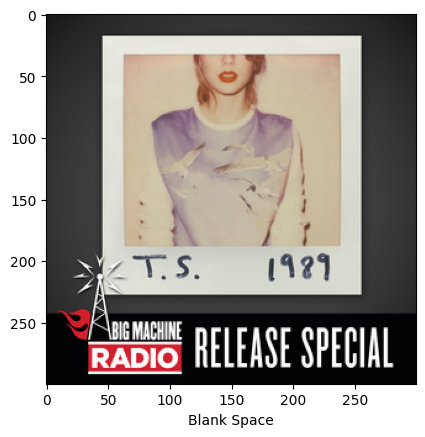

In [0]:
name_music = 'Taylor Swift - Blank Space'
id = projection_kmeans \
    .filter(F.col('artists_song') == name_song) \
    .select('id').collect()[0][0]
track = sp.track(id)

url = track['album']['images'][1]['url']
name = track['name']

image = io.imread(url)
plt.imshow(image)
plt.xlabel(name, fontsize = 10)
plt.show()

In [0]:
def visualize_songs(name, url):
    
    plt.figure(figsize = (15, 10))
    columns = 5

    for i, u in enumerate(url):
        ax = plt.subplot(len(url) // columns + 1, columns, i + 1)
        image = io.imread(u)
        plt.imshow(image)
        ax.get_yaxis().set_visible(False)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(name[i], fontsize = 10)
        plt.tight_layout(h_pad = 0.7, w_pad = 0)
        plt.subplots_adjust(wspace = None, hspace = None)
        plt.grid(visible = None)
    plt.show()

## Testing the function to view the music album

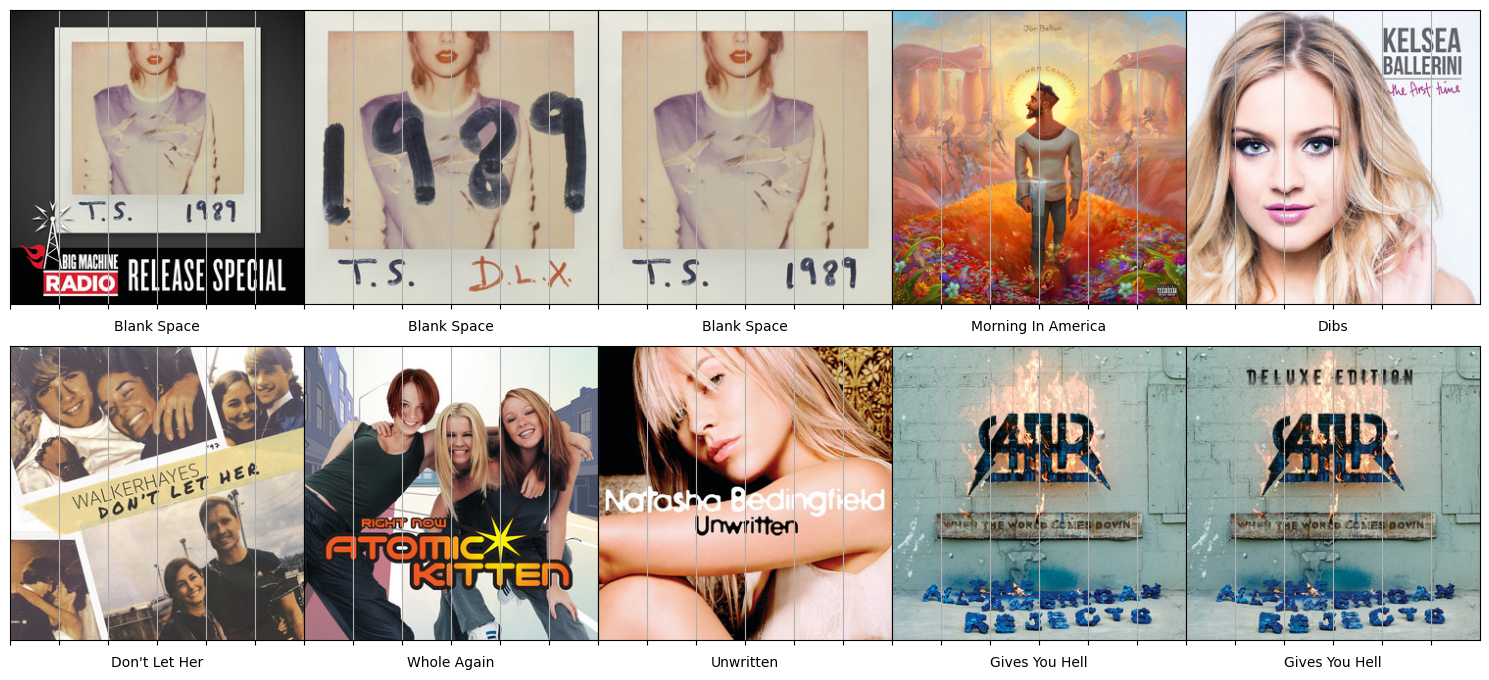

In [0]:
playlist_id = df_recommended \
    .select('id') \
    .collect()

name = list()
url = list()

for i in playlist_id:
    track = sp.track(i[0])
    url.append(track['album']['images'][1]['url'])
    name.append(track['name'])

visualize_songs(name, url)

## Final system

In [0]:
def recommender(name_song):
    # Finding the music cluster
    cluster = projection_kmeans \
        .filter(F.col('artists_song') == name_song) \
        .select('cluster_pca') \
        .collect()[0][0]
    
    # Songs recommended
    songs_recommended = projection_kmeans \
        .filter(F.col('cluster_pca') == cluster) \
        .select('artists_song', 'id', 'pca_features')
    
    # Songs components
    songs_components = songs_recommended \
        .filter(F.col('artists_song') == name_song) \
        .select('pca_features') \
        .collect()[0][0]
    # Calculate distance
    def calculate_distance(value):
        return euclidean(songs_components, value)
    
    udf_calculate_distance = F.udf(calculate_distance, DoubleType())

    songs_recommended_distance = songs_recommended \
        .withColumn('distance', udf_calculate_distance('pca_features'))

    # list recommended
    recommended = spark.createDataFrame(songs_recommended_distance \
        .orderBy(F.col('distance').asc()) \
        .take(10)
    ) \
        .select(['artists_song', 'id', 'distance'])
    
    # Song ID
    id = projection_kmeans \
        .filter(F.col('artists_song') == name_song) \
        .select('id') \
        .collect()[0][0]

    # Playlist_ID
    playlist_id = recommended \
        .select('id') \
        .collect()
    
    # Name and Url

    name = list()
    url = list()

    for i in playlist_id:
        track = sp.track(i[0])
        url.append(track['album']['images'][1]['url'])
        name.append(track['name'])

    # Visualize the recommender
    def visualize_songs(name, url):
    
        plt.figure(figsize = (15, 10))
        columns = 5

        for i, u in enumerate(url):
            ax = plt.subplot(len(url) // columns + 1, columns, i + 1)
            image = io.imread(u)
            plt.imshow(image)
            ax.get_yaxis().set_visible(False)
            plt.xticks(color = 'w', fontsize = 0.1)
            plt.yticks(color = 'w', fontsize = 0.1)
            plt.xlabel(name[i], fontsize = 10)
            plt.tight_layout(h_pad = 0.7, w_pad = 0)
            plt.subplots_adjust(wspace = None, hspace = None)
            plt.grid(visible = None)
        plt.show()

    return visualize_songs(name, url)

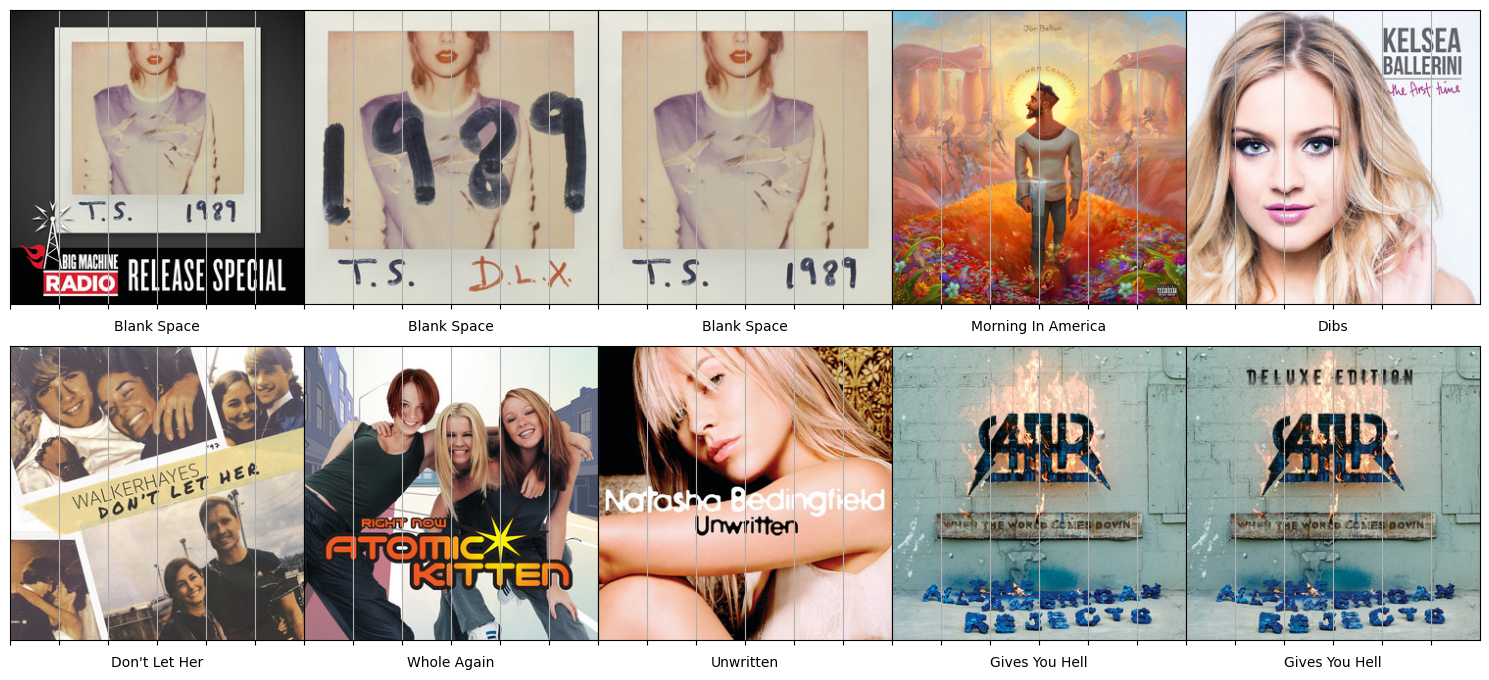

In [0]:
recommender(name_song)

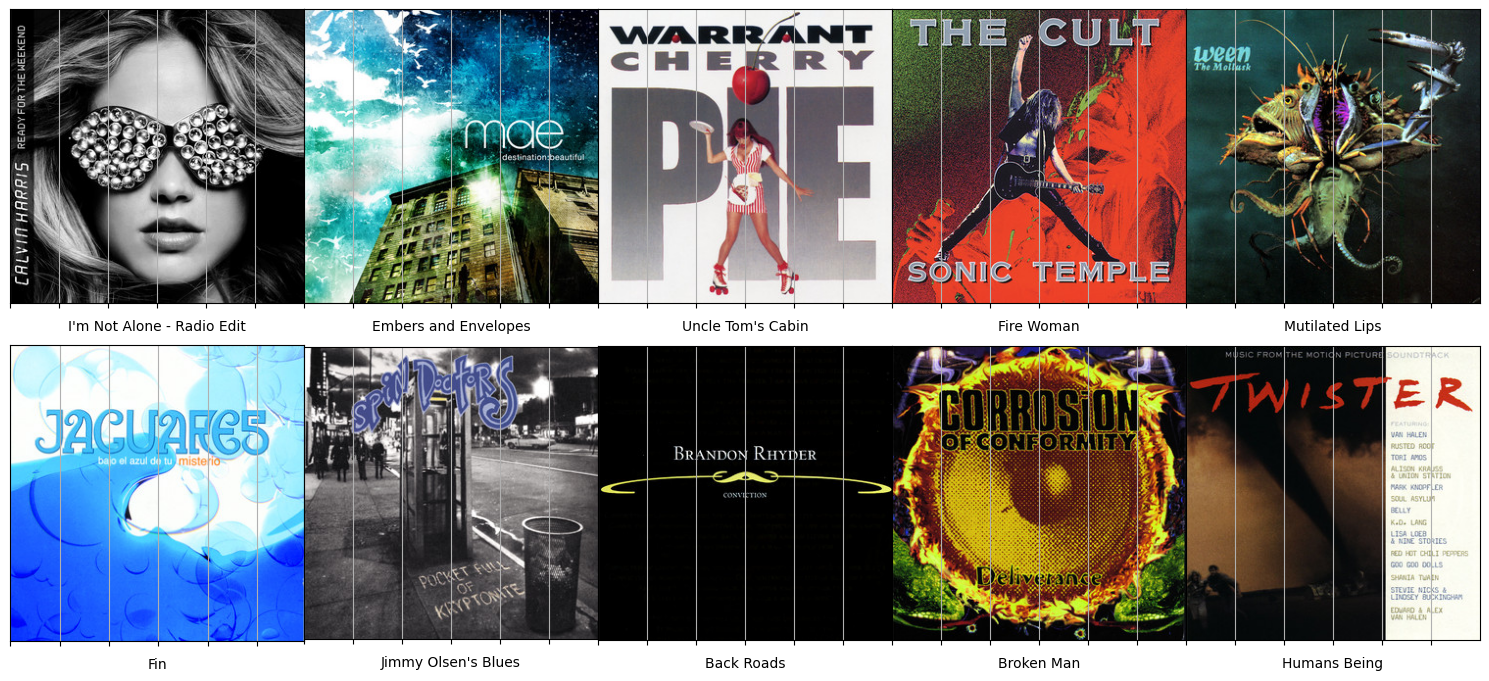

In [0]:
recommender('Calvin Harris - Im Not Alone - Radio Edit')

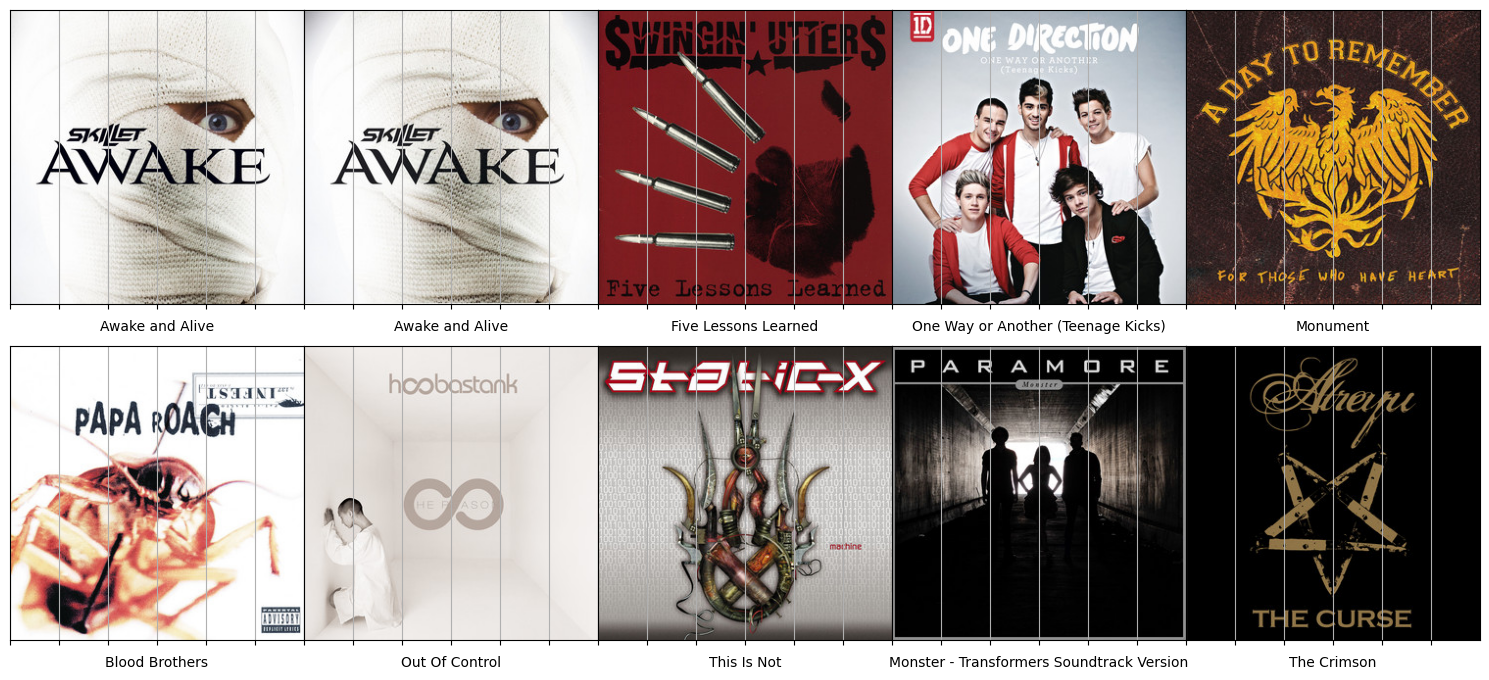

In [0]:
recommender('Skillet - Awake and Alive')

In [0]:
df_data.limit(10).display()

valence year acousticness artists danceability duration_ms energy explicit id instrumentalness key liveness loudness mode name popularity release_date speechiness tempo artists_song 0.917 1970 0.096 The Velvet Underground 0.624 201440 0.774 0 60ZyiL4lmWzZyGfqyECTqp 0.0309 7 0.096 -10.390999999999998 1 Train Round the Bend - 2015 Remaster 24 1970 0.0315 117.006 The Velvet Underground - Train Round the Bend - 2015 Remaster 0.511 1970 0.0019 Ten Years After 0.405 458463 0.5429999999999999 0 6DYyyUdHzI6RdSx0swUR1i 0.72 2 0.18600000000000005 -9.313 1 Love Like a Man - 2017 Remaster 34 1970-04-01 0.029 107.598 Ten Years After - Love Like a Man - 2017 Remaster 0.466 1970 0.0528 The Mothers Of Invention 0.444 105587 0.568 0 6HJAS8XZO0ctUcN2KsbLRa 1.02E-5 11 0.512 -8.8 0 Oh No 24 1970-08-10 0.0327 124.319 The Mothers Of Invention - Oh No 0.523 1970 0.0811 Three Dog Night 0.502 174707 0.669 0 7sZ74qmKb1nyGKUgHROJ1n 9.45E-4 7 0.0906 -11.725 1 One Man Band 19 1970-01-01 0.0912 121.089 Three Dog Night - One Man Band 0.501 1970 1.28E-4 The Rolling Stones 0.273 246413 0.866 0 095WtNlSHE8TMB2gQ1fdTx 0.79 11 0.961 -7.598 1 Street Fighting Man - Live 25 1970-09-04 0.0347 134.891 The Rolling Stones - Street Fighting Man - Live 0.8859999999999999 1970 0.25 Sly & The Family Stone 0.693 178360 0.6409999999999999 0 0aI5KoqucjqXjPi7bFENFQ 5.28E-4 0 0.0826 -9.99 1 Life 18 1970-11-21 0.0517 121.823 Sly & The Family Stone - Life 0.119 1970 0.13 William S. Fischer 0.231 273520 0.326 0 187c6h1frKYjnqKEoKPQQ6 0.287 4 0.106 -18.219 0 Chains 26 1970 0.0425 82.45200000000001 William S. Fischer - Chains 0.61 1970 0.6659999999999999 Yusuf / Cat Stevens 0.397 297107 0.634 0 27adiexGtJvf2NbH0GletP 6.799999999999999E-4 7 0.134 -7.787000000000001 1 On The Road To Find Out - Live At KCET-TV. 1971 27 1970-11-23 0.0343 179.516 Yusuf / Cat Stevens - On The Road To Find Out - Live At KCET-TV. 1971 0.556 1970 0.00674 The Meters 0.601 164000 0.439 0 2SJ5On3CJUop2H2uxTlovf 0.7609999999999999 6 0.0827 -13.213 0 Oh. Calcutta 23 1970 0.0311 102.344 The Meters - Oh. Calcutta 0.317 1970 0.746 Linda Ronstadt 0.341 172707 0.35700000000000004 0 2XCtrbGnYP8inx76lmxXyt 4.47E-6 2 0.454 -13.245 1 Are My Thoughts With YouQ 20 1970 0.0385 123.604 Linda Ronstadt - Are My Thoughts With YouQ